In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

import optuna
import lightgbm as lgbm

from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

from scipy.stats import norm

# Source:

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


# Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


## Attribute Information:

Input variables:
### bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
### related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
### social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

# Load Data

In [2]:
data = pd.read_csv(r"M:\data\bank_marketing\bank-additional-full.csv", delimiter=";")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Split Train/Test

In [3]:
#to ensure equal distribution of labels stratify by label
np.random.seed(35681099)
tr_size = 0.9 #10% of data for testing
#shuffle daata
n = len(data)
shuffle_idx = np.arange(n)
np.random.shuffle(shuffle_idx)
data = data.iloc[shuffle_idx]

#stratify by y
strat_groups = data['y'].unique()

tr_idxs = []
te_idxs = []
for group in strat_groups:
    idxs = data[data['y']==group].index
    
    split_idx = int(tr_size*len(idxs))
    tr_idxs.append(idxs[:split_idx].to_list())
    te_idxs.append(idxs[split_idx:].to_list())

tr_idx = []
list(map(tr_idx.extend, tr_idxs))

te_idx = []
list(map(te_idx.extend, te_idxs))

tr_data = data.iloc[tr_idx].copy()
te_data = data.iloc[te_idx].copy()

In [4]:
def plot_categorical(data, column, order=None):
    #plots probability of subscribing for categories in categorical column
    categories = data[column].unique()
    
    #assert categories.dtype==np.dtype('object'), "categorical columns only"
    
    heights = [] #height of barplots (probabilities)
    ns = [] #number of samples in category
    
    for cat in categories: #collect probabilities
        cat_df = data[data[column]==cat].y
        n = len(cat_df)
        p = cat_df.value_counts()/n
        ns.append(n)
        try:
            heights.append(p.loc['yes'])
        except KeyError:
            heights.append(0)
    
    if order==None:
        sorted_cats = sorted(zip(heights, categories, ns)) #sort by probs  
    else:
        sorted_cats = sorted(zip(heights, categories, ns), key=lambda s: order.index(s[1]))
    

    t = lambda items, i: [item[i] for item in items] 
    heights = [h[0] for h in sorted_cats]
    categories = [c[1] for c in sorted_cats]
    ns = [n[2] for n in sorted_cats]

        
    #plot
    fig, ax = plt.subplots(figsize=(12,7))
    bars = ax.bar(x=categories, height=heights)
    
    #label bar with p
    for i,bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2, height, "n = %.d" % (ns[i],), ha='center', va='bottom')
        
    ax.set_ylabel("% subscribed", fontsize=14)
    ax.set_xlabel(column, fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

## Categorical Variables Interaction on Target

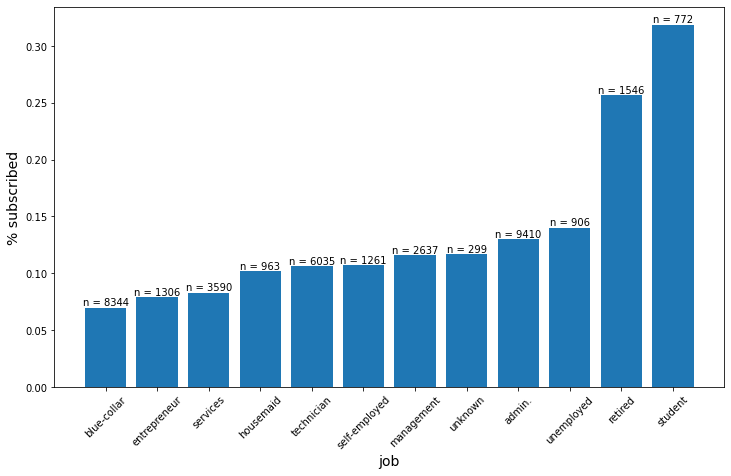

In [5]:
plot_categorical(tr_data, 'job')

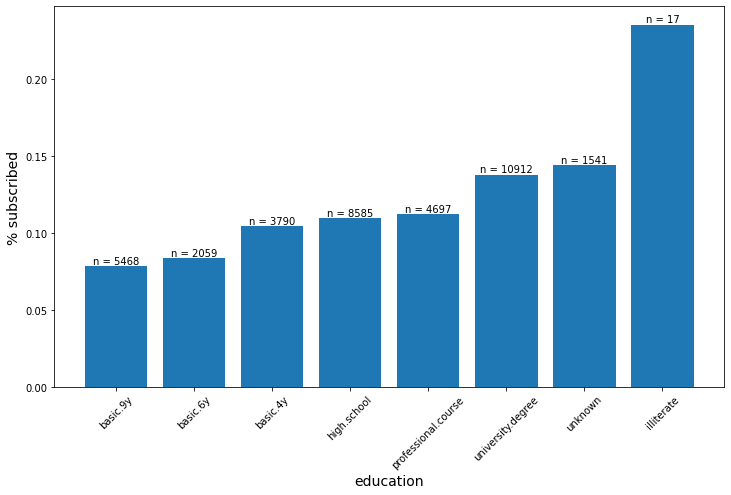

In [6]:
plot_categorical(tr_data, 'education')

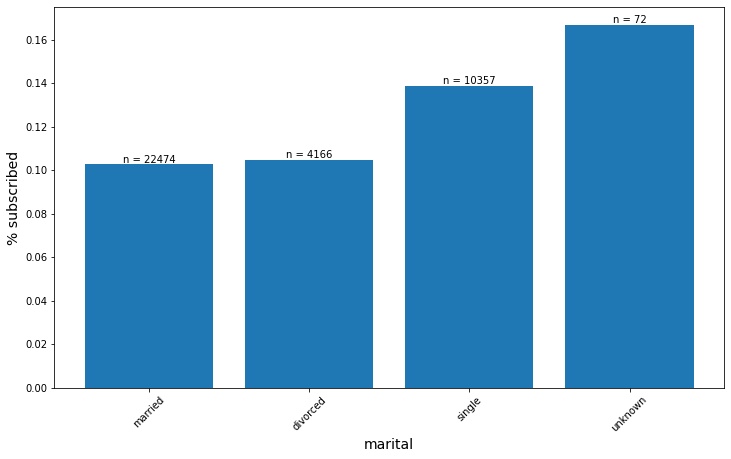

In [7]:
plot_categorical(tr_data, 'marital')

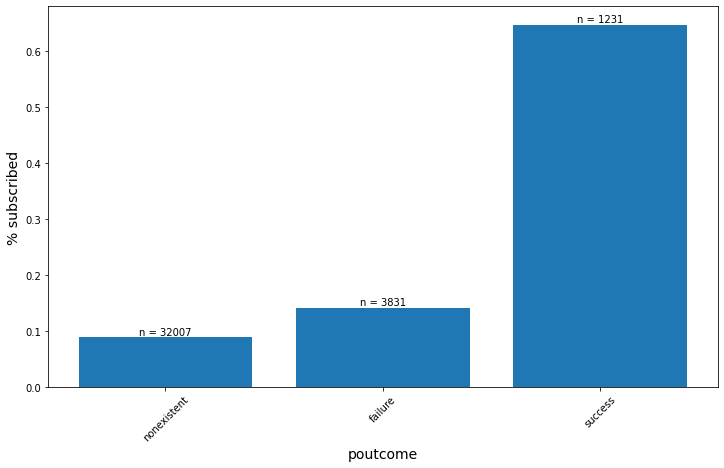

In [8]:
plot_categorical(tr_data, 'poutcome')

## Month/Day Impact on Subscriptions

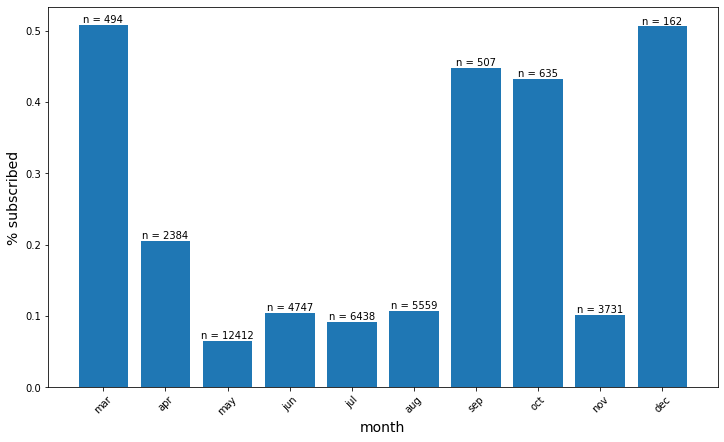

In [9]:
order = ['jan', 'feb' , 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
plot_categorical(tr_data, 'month', order=order)

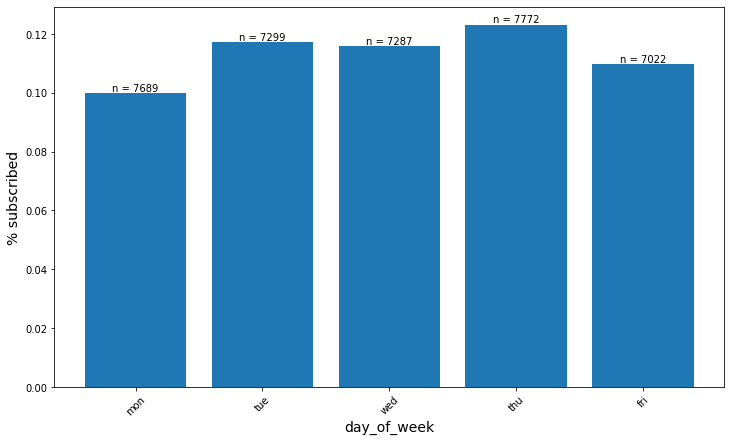

In [10]:
order = ['mon', 'tue', 'wed', 'thu', 'fri']
plot_categorical(tr_data, 'day_of_week', order=order)

#### Don't Make Calls on Mondays (Hypothesis Testing)
Note the following assumes customers were called according to some random process (since we don't 
know the exact process that these calls were made according to; we just assume this assumption isn't violated too harshly).

In [11]:
enc_y = tr_data.replace(['no', 'yes'], [0, 1])
row_df = enc_y[enc_y['day_of_week']!='mon']#rest of week 
mon_df = enc_y[enc_y['day_of_week']=='mon'] #mondays

n_mon = len(mon_df)
n_row = len(row_df)
p_mon = mon_df['y'].sum()/n_mon
p_row = row_df['y'].sum()/n_row
p_pool = (n_mon*p_mon + n_row*p_row)/(n_mon+n_row)
z = p_mon-p_row
z = z / (p_pool * (1-p_pool) * (1/n_mon + 1/n_row))
norm.cdf(z)

0.0

## Numerical Interaction on Target

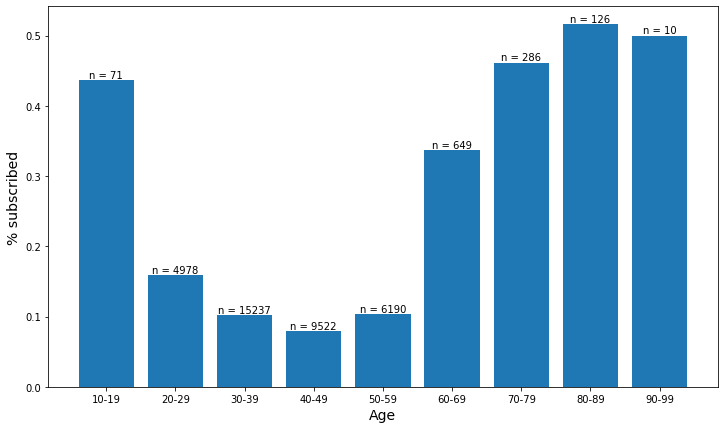

In [12]:
fig, ax = plt.subplots(figsize=(12,7))

ps = []
ns = []
xs = []
for i in range(1,10):
    age1, age2 = 10*i, 10*(i+1)
    age_df = tr_data[(tr_data['age']>=age1) & (tr_data['age']<age2)]
    n = len(age_df)
    p = (age_df['y']=='yes').sum()/n
    ps.append(p)
    ns.append(n)
    xs.append(f"{age1}-{age2-1}")

bars = ax.bar(x=xs, height=ps)

for i,bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2, height, 'n = %.d' % (ns[i],), ha='center', va='bottom')
    
ax.set_ylabel('% subscribed', fontsize=14)
ax.set_xlabel('Age', fontsize=14)
plt.show()

In [13]:
def correlation_indicators(data, indicator):
    
    inds = tr_data[indicator].unique()
    ps = []
    for ind_value in inds:
        ind_df = tr_data[tr_data[indicator]==ind_value]
        p = (ind_df['y']=='yes').sum() / len(ind_df)
        ps.append(p)
        
    return np.corrcoef(inds, ps)[0,1]

In [14]:
indicators = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
sub_chance = [correlation_indicators(tr_data, indicator) for indicator in indicators]

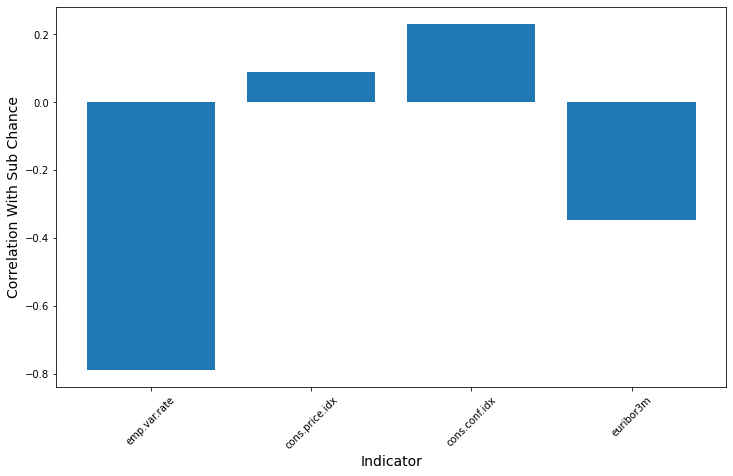

In [15]:
fig, ax = plt.subplots(figsize=(12,7))
bars = ax.bar(x=indicators, height=sub_chance)
        
ax.set_ylabel("Correlation With Sub Chance", fontsize=14)
ax.set_xlabel("Indicator", fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [16]:
def preprocess(data):
    features, targets = data.loc[:, data.columns!='y'].copy(), data.loc[:, 'y'].copy()
    
    #remove columns
    features = features.drop(columns=['duration', 'day_of_week', 'month'])
    
    #group labels within features
    
    #dtypes
    feature_dtypes = features.dtypes
    
    ### Jobs
    job_type1 = ['blue-collar', 'services', 'housemaid', 'self-employed']
    job_type2 = ['entrepreneur', 'technician', 'management', 'admin.']
    job_type3 = ['unknown', 'unemployed', 'retired', 'student']
    job_types = [job_type1, job_type2, job_type3]
    job_replace = {'job':{job:i for i, job_type in enumerate(job_types) for job in job_type}}
    
    ### Education
    edu_type1 = ['basic.9y', 'basic.6y', 'basic.4y', 'illiterate']
    edu_type2 = ['high.school', 'professional.course']
    edu_type3 = ['university.degree', 'unknown']
    edu_types = [edu_type1, edu_type2, edu_type3]
    edu_replace = {'education':{edu:i for i, edu_type in enumerate(edu_types) for edu in edu_type}}
    
    ### Marital
    mar_type1 = ['married', 'divorced']
    mar_type2 = ['unknown', 'single']
    mar_types = [mar_type1, mar_type2]
    mar_replace = {'marital': {mar:i for i,mar_type in enumerate(mar_types) for mar in mar_type}}
    
    ### Default
    def_replace = {'default':{'yes':0, 'unknown':0, 'no':1}}

    ### Loan
    loan_replace = {'loan':{'no':0, 'unknown':0, 'yes':1}}

    ### Housing
    hou_replace = {'housing':{'no':0, 'unknown':0, 'yes':1}}


    ### Previous Outcome
    pout_replace = {'poutcome':{'nonexistent':0, 'failure':0, 'success':1}}
    
    #build replace dictionary 
    group_features = {}
    features_dicts = [job_replace, edu_replace, mar_replace, 
                      def_replace, loan_replace, hou_replace, pout_replace]
    
    for d in features_dicts:
        for k, v in d.items():
            group_features.setdefault(k, v)
            
    
    #replace labels
    features = features.replace(group_features)
    
    #one hot encode features
    features_categoricals = features.loc[:, feature_dtypes=='object']
    features_numerical = features.loc[:, feature_dtypes!='object']
    encoded_categoricals = [pd.get_dummies(features_categoricals[col], prefix=col, drop_first=True)
                            for col in features_categoricals.columns]
    features = pd.concat([features_numerical, *encoded_categoricals], axis=1)
    
    #encode target
    targets = targets.replace(['no', 'yes'], [0, 1])
    
    return features, targets

In [17]:
X_tr, y_tr = preprocess(tr_data)

In [18]:
def objective(trial, X, y):
    param_grid = {
    # "device_type": trial.suggest_categorical("device_type", ['gpu']),
    "n_estimators": trial.suggest_categorical("n_estimators", [8000, 10000, 12000, 14000]),
    "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3),
    "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
    "max_depth": trial.suggest_int("max_depth", 3, 12),
    "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
    "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
    "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
    "bagging_fraction": trial.suggest_float(
    "bagging_fraction", 0.2, 0.95, step=0.05
    ),
    "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
    "feature_fraction": trial.suggest_float(
        "feature_fraction", 0.2, 0.95, step=0.05
        ),
    "max_bin": trial.suggest_int("max_bin", 15, 205, step=10)    
    }
    folds = 5
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1121218)

    cv_scores = np.empty(folds)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", num_threads=-1, **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            verbose=0,
            callbacks=[
                lgbm.early_stopping(100, verbose=False)
            ],
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = metrics.log_loss(y_test, preds)

    return np.mean(cv_scores)

In [19]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_tr, y_tr)
study.optimize(func, n_trials=100)

[I 2022-08-08 01:00:25,337] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=3.6829165488936337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6829165488936337
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=

[I 2022-08-08 01:00:26,013] Trial 0 finished with value: 0.353086607189483 and parameters: {'n_estimators': 8000, 'learning_rate': 0.1455133667017038, 'num_leaves': 1500, 'max_depth': 11, 'lambda_l1': 45, 'lambda_l2': 45, 'min_data_in_leaf': 8000, 'min_gain_to_split': 3.6829165488936337, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8, 'max_bin': 65}. Best is trial 0 with value: 0.353086607189483.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=3.6829165488936337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6829165488936337
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=

[I 2022-08-08 01:00:27,534] Trial 1 finished with value: 0.29938457236465293 and parameters: {'n_estimators': 8000, 'learning_rate': 0.14407703243824893, 'num_leaves': 1260, 'max_depth': 3, 'lambda_l1': 40, 'lambda_l2': 15, 'min_data_in_leaf': 3600, 'min_gain_to_split': 7.513871560192367, 'bagging_fraction': 0.35000000000000003, 'bagging_freq': 1, 'feature_fraction': 0.7, 'max_bin': 35}. Best is trial 1 with value: 0.29938457236465293.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=8.188361895668553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.188361895668553
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.55, subsample=1.0 will be ignored. Current value: bagging_fraction=0.55
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fracti

[I 2022-08-08 01:00:28,746] Trial 2 finished with value: 0.3034313810816063 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23545697369745472, 'num_leaves': 380, 'max_depth': 11, 'lambda_l1': 20, 'lambda_l2': 60, 'min_data_in_leaf': 7300, 'min_gain_to_split': 8.188361895668553, 'bagging_fraction': 0.55, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'max_bin': 65}. Best is trial 1 with value: 0.29938457236465293.


[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=8.188361895668553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.188361895668553
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.55, subsample=1.0 will be ignored. Current value: bagging_fraction=0.55
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samp

[I 2022-08-08 01:00:33,582] Trial 3 finished with value: 0.2896464003381674 and parameters: {'n_estimators': 8000, 'learning_rate': 0.008127397491230919, 'num_leaves': 1160, 'max_depth': 6, 'lambda_l1': 15, 'lambda_l2': 35, 'min_data_in_leaf': 3900, 'min_gain_to_split': 8.759334671229487, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.65, 'max_bin': 15}. Best is trial 3 with value: 0.2896464003381674.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=6.2112538283258285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.2112538283258285
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fracti

[I 2022-08-08 01:00:34,331] Trial 4 finished with value: 0.353086607189483 and parameters: {'n_estimators': 12000, 'learning_rate': 0.22516847097622492, 'num_leaves': 2980, 'max_depth': 12, 'lambda_l1': 90, 'lambda_l2': 85, 'min_data_in_leaf': 4700, 'min_gain_to_split': 6.2112538283258285, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 85}. Best is trial 3 with value: 0.2896464003381674.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=6.2112538283258285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.2112538283258285
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fracti

[I 2022-08-08 01:00:35,967] Trial 5 finished with value: 0.30677712534981455 and parameters: {'n_estimators': 12000, 'learning_rate': 0.08540006368995712, 'num_leaves': 1140, 'max_depth': 4, 'lambda_l1': 70, 'lambda_l2': 45, 'min_data_in_leaf': 5900, 'min_gain_to_split': 14.068609336561583, 'bagging_fraction': 0.45, 'bagging_freq': 1, 'feature_fraction': 0.7, 'max_bin': 45}. Best is trial 3 with value: 0.2896464003381674.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=14.068609336561583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.068609336561583
[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, 

[I 2022-08-08 01:00:36,572] Trial 6 finished with value: 0.353086607189483 and parameters: {'n_estimators': 12000, 'learning_rate': 0.03436597196897215, 'num_leaves': 2160, 'max_depth': 9, 'lambda_l1': 30, 'lambda_l2': 70, 'min_data_in_leaf': 5000, 'min_gain_to_split': 9.593187161144668, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9000000000000001, 'max_bin': 155}. Best is trial 3 with value: 0.2896464003381674.


[LightGBM] [Warning] feature_fraction is set=0.9000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=9.593187161144668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.593187161144668
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction i

[I 2022-08-08 01:00:37,253] Trial 7 finished with value: 0.29097871590557833 and parameters: {'n_estimators': 12000, 'learning_rate': 0.29818814362037493, 'num_leaves': 100, 'max_depth': 10, 'lambda_l1': 85, 'lambda_l2': 10, 'min_data_in_leaf': 2500, 'min_gain_to_split': 8.392293437800445, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.65, 'max_bin': 65}. Best is trial 3 with value: 0.2896464003381674.


[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=11.040993213422635, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.040993213422635
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytr

[I 2022-08-08 01:00:38,357] Trial 8 finished with value: 0.29217062716415054 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25754781588666975, 'num_leaves': 1920, 'max_depth': 10, 'lambda_l1': 40, 'lambda_l2': 60, 'min_data_in_leaf': 2100, 'min_gain_to_split': 11.040993213422635, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.65, 'max_bin': 45}. Best is trial 3 with value: 0.2896464003381674.


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=7.891851962889166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.891851962889166
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytr

[I 2022-08-08 01:00:39,307] Trial 9 finished with value: 0.28999925520907627 and parameters: {'n_estimators': 8000, 'learning_rate': 0.23765375123171012, 'num_leaves': 1040, 'max_depth': 5, 'lambda_l1': 35, 'lambda_l2': 90, 'min_data_in_leaf': 4400, 'min_gain_to_split': 7.891851962889166, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.25, 'max_bin': 95}. Best is trial 3 with value: 0.2896464003381674.


[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=7.891851962889166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.891851962889166
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samp

[I 2022-08-08 01:00:59,814] Trial 10 finished with value: 0.2944943670297068 and parameters: {'n_estimators': 14000, 'learning_rate': 0.023310566692462696, 'num_leaves': 680, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 30, 'min_data_in_leaf': 9500, 'min_gain_to_split': 0.27701502800724054, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.45, 'max_bin': 145}. Best is trial 3 with value: 0.2896464003381674.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.265568122359676, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.265568122359676
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.

[I 2022-08-08 01:01:01,341] Trial 11 finished with value: 0.27855467222566477 and parameters: {'n_estimators': 8000, 'learning_rate': 0.18964701611831838, 'num_leaves': 880, 'max_depth': 6, 'lambda_l1': 5, 'lambda_l2': 100, 'min_data_in_leaf': 500, 'min_gain_to_split': 4.265568122359676, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.2, 'max_bin': 125}. Best is trial 11 with value: 0.27855467222566477.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.126033477338845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.126033477338845
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.

[I 2022-08-08 01:01:03,221] Trial 12 finished with value: 0.2781260118739851 and parameters: {'n_estimators': 8000, 'learning_rate': 0.17890532623036762, 'num_leaves': 720, 'max_depth': 6, 'lambda_l1': 5, 'lambda_l2': 100, 'min_data_in_leaf': 800, 'min_gain_to_split': 4.126033477338845, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.5, 'max_bin': 195}. Best is trial 12 with value: 0.2781260118739851.


[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.368927953004409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.368927953004409
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree

[I 2022-08-08 01:01:05,371] Trial 13 finished with value: 0.27629749191873165 and parameters: {'n_estimators': 8000, 'learning_rate': 0.18564512697487662, 'num_leaves': 660, 'max_depth': 8, 'lambda_l1': 0, 'lambda_l2': 100, 'min_data_in_leaf': 400, 'min_gain_to_split': 3.368927953004409, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.45, 'max_bin': 205}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=1.1201548004598867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1201548004598867
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytre

[I 2022-08-08 01:01:07,274] Trial 14 finished with value: 0.28312488745919095 and parameters: {'n_estimators': 14000, 'learning_rate': 0.17712862842086868, 'num_leaves': 340, 'max_depth': 8, 'lambda_l1': 65, 'lambda_l2': 100, 'min_data_in_leaf': 300, 'min_gain_to_split': 1.1201548004598867, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.5, 'max_bin': 205}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.35000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35000000000000003
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=2.908129510491256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.908129510491256
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction

[I 2022-08-08 01:01:10,338] Trial 15 finished with value: 0.2852661356280185 and parameters: {'n_estimators': 8000, 'learning_rate': 0.11300338000464402, 'num_leaves': 560, 'max_depth': 8, 'lambda_l1': 15, 'lambda_l2': 80, 'min_data_in_leaf': 1600, 'min_gain_to_split': 2.908129510491256, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.35000000000000003, 'max_bin': 205}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=5.2207026903498175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.2207026903498175
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=

[I 2022-08-08 01:01:12,854] Trial 16 finished with value: 0.2834660010493178 and parameters: {'n_estimators': 8000, 'learning_rate': 0.18895165176820997, 'num_leaves': 60, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 75, 'min_data_in_leaf': 1400, 'min_gain_to_split': 5.2207026903498175, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.5, 'max_bin': 175}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.7681144179357267, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7681144179357267
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytr

[I 2022-08-08 01:01:15,144] Trial 17 finished with value: 0.282816131899493 and parameters: {'n_estimators': 8000, 'learning_rate': 0.0906990240951512, 'num_leaves': 1840, 'max_depth': 5, 'lambda_l1': 55, 'lambda_l2': 100, 'min_data_in_leaf': 200, 'min_gain_to_split': 1.7681144179357267, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.55, 'max_bin': 175}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=5.787081907463321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.787081907463321
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction i

[I 2022-08-08 01:01:16,309] Trial 18 finished with value: 0.28819378041147825 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2051503494188993, 'num_leaves': 780, 'max_depth': 9, 'lambda_l1': 25, 'lambda_l2': 90, 'min_data_in_leaf': 3000, 'min_gain_to_split': 5.787081907463321, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 185}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=6100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6100
[LightGBM] [Warning] min_gain_to_split is set=2.3085588456929527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3085588456929527
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fracti

[I 2022-08-08 01:01:22,144] Trial 19 finished with value: 0.2861377393536567 and parameters: {'n_estimators': 14000, 'learning_rate': 0.2746020536180667, 'num_leaves': 1500, 'max_depth': 6, 'lambda_l1': 10, 'lambda_l2': 65, 'min_data_in_leaf': 6100, 'min_gain_to_split': 2.3085588456929527, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.55, 'max_bin': 125}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=4.329122825191373, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.329122825191373
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_by

[I 2022-08-08 01:01:23,188] Trial 20 finished with value: 0.2920193631033297 and parameters: {'n_estimators': 8000, 'learning_rate': 0.16210103295451006, 'num_leaves': 2420, 'max_depth': 3, 'lambda_l1': 100, 'lambda_l2': 85, 'min_data_in_leaf': 1500, 'min_gain_to_split': 4.329122825191373, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.95, 'max_bin': 145}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=4.329122825191373, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.329122825191373
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_byt

[I 2022-08-08 01:01:25,183] Trial 21 finished with value: 0.27852797359656845 and parameters: {'n_estimators': 8000, 'learning_rate': 0.20058800207643016, 'num_leaves': 920, 'max_depth': 6, 'lambda_l1': 5, 'lambda_l2': 100, 'min_data_in_leaf': 800, 'min_gain_to_split': 4.144247611882627, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2, 'max_bin': 195}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.21402337898067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.21402337898067
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is se

[I 2022-08-08 01:01:27,192] Trial 22 finished with value: 0.2787218260235245 and parameters: {'n_estimators': 8000, 'learning_rate': 0.21341807304564325, 'num_leaves': 520, 'max_depth': 5, 'lambda_l1': 10, 'lambda_l2': 95, 'min_data_in_leaf': 700, 'min_gain_to_split': 3.21402337898067, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2, 'max_bin': 195}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=6.077490672366698, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.077490672366698
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction i

[I 2022-08-08 01:01:29,093] Trial 23 finished with value: 0.28668831586462684 and parameters: {'n_estimators': 8000, 'learning_rate': 0.13328875518130925, 'num_leaves': 920, 'max_depth': 7, 'lambda_l1': 0, 'lambda_l2': 75, 'min_data_in_leaf': 3200, 'min_gain_to_split': 6.077490672366698, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'max_bin': 165}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.05825389328706354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05825389328706354
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytre

[I 2022-08-08 01:01:36,532] Trial 24 finished with value: 0.28011184720611737 and parameters: {'n_estimators': 8000, 'learning_rate': 0.17406276094130604, 'num_leaves': 280, 'max_depth': 8, 'lambda_l1': 25, 'lambda_l2': 85, 'min_data_in_leaf': 2100, 'min_gain_to_split': 0.05825389328706354, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 185}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=5.206922955107401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.206922955107401
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightG

[I 2022-08-08 01:01:38,990] Trial 25 finished with value: 0.28046388505098074 and parameters: {'n_estimators': 8000, 'learning_rate': 0.12287901566555659, 'num_leaves': 1280, 'max_depth': 4, 'lambda_l1': 10, 'lambda_l2': 95, 'min_data_in_leaf': 1000, 'min_gain_to_split': 5.206922955107401, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'max_bin': 205}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=1.5341726762208667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5341726762208667
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_

[I 2022-08-08 01:01:42,282] Trial 26 finished with value: 0.28562299632541466 and parameters: {'n_estimators': 8000, 'learning_rate': 0.19933492889201637, 'num_leaves': 700, 'max_depth': 6, 'lambda_l1': 25, 'lambda_l2': 100, 'min_data_in_leaf': 2500, 'min_gain_to_split': 1.5341726762208667, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.45, 'max_bin': 185}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.4947153041555685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.4947153041555685
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fracti

[I 2022-08-08 01:01:44,379] Trial 27 finished with value: 0.2815816318087743 and parameters: {'n_estimators': 14000, 'learning_rate': 0.10079386252420058, 'num_leaves': 940, 'max_depth': 9, 'lambda_l1': 15, 'lambda_l2': 90, 'min_data_in_leaf': 1000, 'min_gain_to_split': 6.4947153041555685, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'max_bin': 165}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=4.401794965965591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.401794965965591
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 

[I 2022-08-08 01:01:45,375] Trial 28 finished with value: 0.2883052695660059 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1595914784986669, 'num_leaves': 560, 'max_depth': 7, 'lambda_l1': 55, 'lambda_l2': 0, 'min_data_in_leaf': 1800, 'min_gain_to_split': 4.401794965965591, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8, 'max_bin': 125}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=4.401794965965591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.401794965965591
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.35000000000000003, colsa

[I 2022-08-08 01:01:49,470] Trial 29 finished with value: 0.29004666649480604 and parameters: {'n_estimators': 8000, 'learning_rate': 0.15094090589931536, 'num_leaves': 1740, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 55, 'min_data_in_leaf': 9400, 'min_gain_to_split': 3.5413182574416786, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.35000000000000003, 'max_bin': 145}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.582580937709645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.582580937709645
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.55, subsample=1.0 will be ignored. Current value: bagging_fraction=0.55
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.

[I 2022-08-08 01:01:55,611] Trial 30 finished with value: 0.28346380658741144 and parameters: {'n_estimators': 8000, 'learning_rate': 0.06238833281357396, 'num_leaves': 1380, 'max_depth': 4, 'lambda_l1': 5, 'lambda_l2': 75, 'min_data_in_leaf': 2900, 'min_gain_to_split': 2.582580937709645, 'bagging_fraction': 0.55, 'bagging_freq': 1, 'feature_fraction': 0.8, 'max_bin': 195}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.125879135139042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.125879135139042
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is 

[I 2022-08-08 01:01:57,528] Trial 31 finished with value: 0.2781907374528408 and parameters: {'n_estimators': 8000, 'learning_rate': 0.1824414131548819, 'num_leaves': 840, 'max_depth': 6, 'lambda_l1': 5, 'lambda_l2': 100, 'min_data_in_leaf': 200, 'min_gain_to_split': 4.125879135139042, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2, 'max_bin': 125}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=6.940899160527289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.940899160527289
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction i

[I 2022-08-08 01:01:58,688] Trial 32 finished with value: 0.2869480451274508 and parameters: {'n_estimators': 8000, 'learning_rate': 0.21376509494369098, 'num_leaves': 780, 'max_depth': 6, 'lambda_l1': 20, 'lambda_l2': 95, 'min_data_in_leaf': 1100, 'min_gain_to_split': 6.940899160527289, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2, 'max_bin': 105}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=6.940899160527289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.940899160527289
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction i

[I 2022-08-08 01:02:00,153] Trial 33 finished with value: 0.278491707155431 and parameters: {'n_estimators': 8000, 'learning_rate': 0.25060883949764945, 'num_leaves': 420, 'max_depth': 7, 'lambda_l1': 5, 'lambda_l2': 80, 'min_data_in_leaf': 300, 'min_gain_to_split': 5.090497580084269, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'max_bin': 165}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.35000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35000000000000003
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.0222736325429995, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.0222736325429995
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction

[I 2022-08-08 01:02:01,727] Trial 34 finished with value: 0.2809941741658143 and parameters: {'n_estimators': 8000, 'learning_rate': 0.2433881277152433, 'num_leaves': 200, 'max_depth': 8, 'lambda_l1': 20, 'lambda_l2': 80, 'min_data_in_leaf': 200, 'min_gain_to_split': 5.0222736325429995, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.35000000000000003, 'max_bin': 155}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] min_gain_to_split is set=7.140682310812436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.140682310812436
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree

[I 2022-08-08 01:02:03,018] Trial 35 finished with value: 0.2941860928038197 and parameters: {'n_estimators': 8000, 'learning_rate': 0.2615812248782368, 'num_leaves': 340, 'max_depth': 7, 'lambda_l1': 10, 'lambda_l2': 90, 'min_data_in_leaf': 8300, 'min_gain_to_split': 7.140682310812436, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.25, 'max_bin': 175}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] min_gain_to_split is set=3.763915894396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.763915894396
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is se

[I 2022-08-08 01:02:04,664] Trial 36 finished with value: 0.2885313427875625 and parameters: {'n_estimators': 8000, 'learning_rate': 0.13969025024997733, 'num_leaves': 500, 'max_depth': 10, 'lambda_l1': 35, 'lambda_l2': 35, 'min_data_in_leaf': 3800, 'min_gain_to_split': 3.763915894396, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.45, 'max_bin': 165}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=9.424158289377509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.424158289377509
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction

[I 2022-08-08 01:02:05,384] Trial 37 finished with value: 0.3515737824058928 and parameters: {'n_estimators': 12000, 'learning_rate': 0.22784292860768024, 'num_leaves': 1120, 'max_depth': 9, 'lambda_l1': 15, 'lambda_l2': 80, 'min_data_in_leaf': 5900, 'min_gain_to_split': 9.424158289377509, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'max_bin': 115}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=9.424158289377509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.424158289377509
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction

[I 2022-08-08 01:02:07,919] Trial 38 finished with value: 0.2939566907181882 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29951027230887217, 'num_leaves': 420, 'max_depth': 8, 'lambda_l1': 5, 'lambda_l2': 65, 'min_data_in_leaf': 6900, 'min_gain_to_split': 2.2298975130379017, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.25, 'max_bin': 135}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=14.394961277650987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.394961277650987
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytre

[I 2022-08-08 01:02:08,856] Trial 39 finished with value: 0.2886808261787085 and parameters: {'n_estimators': 12000, 'learning_rate': 0.17500555135980408, 'num_leaves': 2900, 'max_depth': 7, 'lambda_l1': 30, 'lambda_l2': 95, 'min_data_in_leaf': 2200, 'min_gain_to_split': 14.394961277650987, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.5, 'max_bin': 85}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=14.394961277650987, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.394961277650987
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, 

[I 2022-08-08 01:02:09,703] Trial 40 finished with value: 0.289413191643325 and parameters: {'n_estimators': 8000, 'learning_rate': 0.2735211929847906, 'num_leaves': 180, 'max_depth': 4, 'lambda_l1': 45, 'lambda_l2': 50, 'min_data_in_leaf': 1200, 'min_gain_to_split': 12.537469219600055, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'max_bin': 155}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.7165043667334636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7165043667334636
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction

[I 2022-08-08 01:02:11,636] Trial 41 finished with value: 0.278202854743998 and parameters: {'n_estimators': 8000, 'learning_rate': 0.19533371919906306, 'num_leaves': 1000, 'max_depth': 6, 'lambda_l1': 5, 'lambda_l2': 100, 'min_data_in_leaf': 700, 'min_gain_to_split': 3.7165043667334636, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.25, 'max_bin': 195}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=3.385773212989911, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.385773212989911
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is 

[I 2022-08-08 01:02:13,538] Trial 42 finished with value: 0.2769911860544415 and parameters: {'n_estimators': 8000, 'learning_rate': 0.2181802884434572, 'num_leaves': 660, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 85, 'min_data_in_leaf': 700, 'min_gain_to_split': 3.385773212989911, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.25, 'max_bin': 195}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.025730996962106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.025730996962106
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is 

[I 2022-08-08 01:02:15,847] Trial 43 finished with value: 0.27713226906927096 and parameters: {'n_estimators': 8000, 'learning_rate': 0.22213473640758324, 'num_leaves': 1060, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 85, 'min_data_in_leaf': 700, 'min_gain_to_split': 1.025730996962106, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.25, 'max_bin': 15}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.8372928590349158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8372928590349158
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=

[I 2022-08-08 01:02:18,960] Trial 44 finished with value: 0.281118314708125 and parameters: {'n_estimators': 8000, 'learning_rate': 0.2217617467667036, 'num_leaves': 1280, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 90, 'min_data_in_leaf': 1700, 'min_gain_to_split': 0.8372928590349158, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 35}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.824288690991289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.824288690991289
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree

[I 2022-08-08 01:02:21,068] Trial 45 finished with value: 0.2899561176791835 and parameters: {'n_estimators': 8000, 'learning_rate': 0.18451269539612405, 'num_leaves': 680, 'max_depth': 5, 'lambda_l1': 75, 'lambda_l2': 95, 'min_data_in_leaf': 2500, 'min_gain_to_split': 0.824288690991289, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.25, 'max_bin': 15}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.35000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35000000000000003
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.9836954824555146, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9836954824555146
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightG

[I 2022-08-08 01:02:23,014] Trial 46 finished with value: 0.27882466900823055 and parameters: {'n_estimators': 14000, 'learning_rate': 0.23366829082551485, 'num_leaves': 1160, 'max_depth': 3, 'lambda_l1': 15, 'lambda_l2': 85, 'min_data_in_leaf': 700, 'min_gain_to_split': 1.9836954824555146, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.35000000000000003, 'max_bin': 55}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=2.58129282926501, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.58129282926501
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is 

[I 2022-08-08 01:02:25,019] Trial 47 finished with value: 0.2841937543641506 and parameters: {'n_estimators': 12000, 'learning_rate': 0.21350898638985077, 'num_leaves': 780, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 70, 'min_data_in_leaf': 1300, 'min_gain_to_split': 2.58129282926501, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.45, 'max_bin': 15}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=3.121684118378247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.121684118378247
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree

[I 2022-08-08 01:02:28,671] Trial 48 finished with value: 0.29227906994043273 and parameters: {'n_estimators': 8000, 'learning_rate': 0.1806336153157598, 'num_leaves': 1620, 'max_depth': 12, 'lambda_l1': 20, 'lambda_l2': 20, 'min_data_in_leaf': 2000, 'min_gain_to_split': 3.121684118378247, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.75, 'max_bin': 75}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=1.3073306278705283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3073306278705283
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytre

[I 2022-08-08 01:02:34,782] Trial 49 finished with value: 0.2842553084791446 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16388608588403036, 'num_leaves': 1060, 'max_depth': 5, 'lambda_l1': 10, 'lambda_l2': 85, 'min_data_in_leaf': 4400, 'min_gain_to_split': 1.3073306278705283, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.2, 'max_bin': 205}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.713075895772534, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.713075895772534
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 wi

[I 2022-08-08 01:02:36,550] Trial 50 finished with value: 0.27806742882628555 and parameters: {'n_estimators': 8000, 'learning_rate': 0.1471955406546226, 'num_leaves': 640, 'max_depth': 4, 'lambda_l1': 0, 'lambda_l2': 95, 'min_data_in_leaf': 500, 'min_gain_to_split': 5.713075895772534, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7, 'max_bin': 95}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.713075895772534, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.713075895772534
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 wi

[I 2022-08-08 01:02:38,088] Trial 51 finished with value: 0.27836713327598367 and parameters: {'n_estimators': 8000, 'learning_rate': 0.14276840983486772, 'num_leaves': 640, 'max_depth': 4, 'lambda_l1': 0, 'lambda_l2': 95, 'min_data_in_leaf': 600, 'min_gain_to_split': 5.679784800545036, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7, 'max_bin': 95}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=4.682399600444073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.682399600444073
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree

[I 2022-08-08 01:02:39,758] Trial 52 finished with value: 0.28470156723858275 and parameters: {'n_estimators': 8000, 'learning_rate': 0.1560822068571961, 'num_leaves': 840, 'max_depth': 3, 'lambda_l1': 5, 'lambda_l2': 100, 'min_data_in_leaf': 1200, 'min_gain_to_split': 4.682399600444073, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.65, 'max_bin': 75}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.8500000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8500000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.0586757590999616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0586757590999616
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction i

[I 2022-08-08 01:02:41,506] Trial 53 finished with value: 0.27832009678528186 and parameters: {'n_estimators': 8000, 'learning_rate': 0.20879596993276964, 'num_leaves': 660, 'max_depth': 4, 'lambda_l1': 10, 'lambda_l2': 90, 'min_data_in_leaf': 200, 'min_gain_to_split': 3.0586757590999616, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8500000000000001, 'max_bin': 25}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.8500000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8500000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.0586757590999616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0586757590999616
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction i

[I 2022-08-08 01:02:44,665] Trial 54 finished with value: 0.2840941281335622 and parameters: {'n_estimators': 8000, 'learning_rate': 0.1736955342167899, 'num_leaves': 1200, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 100, 'min_data_in_leaf': 1500, 'min_gain_to_split': 4.031228441620218, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.55, 'max_bin': 55}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.723709017353983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.723709017353983
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 

[I 2022-08-08 01:02:45,861] Trial 55 finished with value: 0.2798983844534889 and parameters: {'n_estimators': 8000, 'learning_rate': 0.1279793020823029, 'num_leaves': 580, 'max_depth': 5, 'lambda_l1': 5, 'lambda_l2': 95, 'min_data_in_leaf': 600, 'min_gain_to_split': 7.723709017353983, 'bagging_fraction': 0.95, 'bagging_freq': 1, 'feature_fraction': 0.7, 'max_bin': 105}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.723709017353983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.723709017353983
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0

[I 2022-08-08 01:02:47,506] Trial 56 finished with value: 0.28093234414240575 and parameters: {'n_estimators': 8000, 'learning_rate': 0.19805307589071258, 'num_leaves': 840, 'max_depth': 6, 'lambda_l1': 15, 'lambda_l2': 85, 'min_data_in_leaf': 1000, 'min_gain_to_split': 5.664819282504326, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.75, 'max_bin': 185}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.550391385718093, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.550391385718093
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree

[I 2022-08-08 01:02:49,691] Trial 57 finished with value: 0.27927781487525066 and parameters: {'n_estimators': 14000, 'learning_rate': 0.1673632628619195, 'num_leaves': 1040, 'max_depth': 5, 'lambda_l1': 10, 'lambda_l2': 90, 'min_data_in_leaf': 500, 'min_gain_to_split': 4.550391385718093, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.25, 'max_bin': 205}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.5138876455572876, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5138876455572876
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction i

[I 2022-08-08 01:02:52,022] Trial 58 finished with value: 0.27824932627405186 and parameters: {'n_estimators': 8000, 'learning_rate': 0.21976886241588753, 'num_leaves': 440, 'max_depth': 4, 'lambda_l1': 0, 'lambda_l2': 70, 'min_data_in_leaf': 1700, 'min_gain_to_split': 0.5138876455572876, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5, 'max_bin': 45}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.424280629470587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.424280629470587
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is 

[I 2022-08-08 01:02:53,894] Trial 59 finished with value: 0.28018781807783183 and parameters: {'n_estimators': 8000, 'learning_rate': 0.11633414589031321, 'num_leaves': 760, 'max_depth': 7, 'lambda_l1': 20, 'lambda_l2': 95, 'min_data_in_leaf': 900, 'min_gain_to_split': 3.424280629470587, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'max_bin': 195}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.287832975458543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.287832975458543
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is 

[I 2022-08-08 01:02:55,681] Trial 60 finished with value: 0.2802738455478925 and parameters: {'n_estimators': 12000, 'learning_rate': 0.19029424252251922, 'num_leaves': 20, 'max_depth': 8, 'lambda_l1': 10, 'lambda_l2': 40, 'min_data_in_leaf': 200, 'min_gain_to_split': 6.287832975458543, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2, 'max_bin': 175}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.869311070957751, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.869311070957751
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction i

[I 2022-08-08 01:02:57,445] Trial 61 finished with value: 0.2782196060846152 and parameters: {'n_estimators': 8000, 'learning_rate': 0.1962595090463071, 'num_leaves': 980, 'max_depth': 6, 'lambda_l1': 5, 'lambda_l2': 100, 'min_data_in_leaf': 600, 'min_gain_to_split': 3.869311070957751, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.25, 'max_bin': 195}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=2.6828019780501364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6828019780501364
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9000000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Ligh

[I 2022-08-08 01:02:59,428] Trial 62 finished with value: 0.2831032465675162 and parameters: {'n_estimators': 8000, 'learning_rate': 0.18639683855407568, 'num_leaves': 1420, 'max_depth': 6, 'lambda_l1': 5, 'lambda_l2': 100, 'min_data_in_leaf': 1400, 'min_gain_to_split': 2.6828019780501364, 'bagging_fraction': 0.9000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'max_bin': 185}. Best is trial 13 with value: 0.27629749191873165.


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.8461580489923979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8461580489923979
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytr

[I 2022-08-08 01:03:03,963] Trial 63 finished with value: 0.2748006082915227 and parameters: {'n_estimators': 8000, 'learning_rate': 0.20305001205148426, 'num_leaves': 1020, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 100, 'min_data_in_leaf': 800, 'min_gain_to_split': 1.8461580489923979, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.25, 'max_bin': 205}. Best is trial 63 with value: 0.2748006082915227.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.9613254521881374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9613254521881374
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=

[I 2022-08-08 01:03:07,405] Trial 64 finished with value: 0.27483148644754796 and parameters: {'n_estimators': 8000, 'learning_rate': 0.23234827608608638, 'num_leaves': 880, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 90, 'min_data_in_leaf': 1000, 'min_gain_to_split': 1.9613254521881374, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 205}. Best is trial 63 with value: 0.2748006082915227.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=1.7622926437170627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7622926437170627
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=

[I 2022-08-08 01:03:11,997] Trial 65 finished with value: 0.28024919682134736 and parameters: {'n_estimators': 8000, 'learning_rate': 0.23590542096518521, 'num_leaves': 620, 'max_depth': 4, 'lambda_l1': 0, 'lambda_l2': 90, 'min_data_in_leaf': 2300, 'min_gain_to_split': 1.7622926437170627, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 205}. Best is trial 63 with value: 0.2748006082915227.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=1.3125200944674973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3125200944674973
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.

[I 2022-08-08 01:03:16,132] Trial 66 finished with value: 0.27951069118831784 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24654789436788707, 'num_leaves': 1360, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 80, 'min_data_in_leaf': 2900, 'min_gain_to_split': 1.3125200944674973, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5, 'max_bin': 205}. Best is trial 63 with value: 0.2748006082915227.


[LightGBM] [Warning] feature_fraction is set=0.35000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35000000000000003
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=0.008107176591976462, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008107176591976462
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fr

[I 2022-08-08 01:03:18,885] Trial 67 finished with value: 0.27828409789997005 and parameters: {'n_estimators': 8000, 'learning_rate': 0.26129277181256866, 'num_leaves': 940, 'max_depth': 5, 'lambda_l1': 0, 'lambda_l2': 85, 'min_data_in_leaf': 1800, 'min_gain_to_split': 0.008107176591976462, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.35000000000000003, 'max_bin': 185}. Best is trial 63 with value: 0.2748006082915227.


[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=2.0615321759283978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0615321759283978
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_

[I 2022-08-08 01:03:20,026] Trial 68 finished with value: 0.29255339200420793 and parameters: {'n_estimators': 8000, 'learning_rate': 0.20485103141796934, 'num_leaves': 500, 'max_depth': 7, 'lambda_l1': 100, 'lambda_l2': 75, 'min_data_in_leaf': 3400, 'min_gain_to_split': 2.0615321759283978, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.45, 'max_bin': 195}. Best is trial 63 with value: 0.2748006082915227.


[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=2.0615321759283978, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0615321759283978
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_s

[I 2022-08-08 01:03:24,090] Trial 69 finished with value: 0.2741115670078786 and parameters: {'n_estimators': 14000, 'learning_rate': 0.2301700059179702, 'num_leaves': 240, 'max_depth': 4, 'lambda_l1': 10, 'lambda_l2': 95, 'min_data_in_leaf': 900, 'min_gain_to_split': 0.7333073950501294, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.55, 'max_bin': 205}. Best is trial 69 with value: 0.2741115670078786.


[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.42393777464184845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.42393777464184845
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_by

[I 2022-08-08 01:03:28,221] Trial 70 finished with value: 0.27412907452583835 and parameters: {'n_estimators': 14000, 'learning_rate': 0.2850993701679019, 'num_leaves': 300, 'max_depth': 3, 'lambda_l1': 15, 'lambda_l2': 90, 'min_data_in_leaf': 1000, 'min_gain_to_split': 0.42393777464184845, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.55, 'max_bin': 175}. Best is trial 69 with value: 0.2741115670078786.


[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.5376835675231315, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5376835675231315
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree

[I 2022-08-08 01:03:30,305] Trial 71 finished with value: 0.2764055522896823 and parameters: {'n_estimators': 14000, 'learning_rate': 0.28289308943969405, 'num_leaves': 280, 'max_depth': 3, 'lambda_l1': 10, 'lambda_l2': 90, 'min_data_in_leaf': 900, 'min_gain_to_split': 1.5376835675231315, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.55, 'max_bin': 205}. Best is trial 69 with value: 0.2741115670078786.


[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.5335840944264709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5335840944264709
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytr

[I 2022-08-08 01:03:33,350] Trial 72 finished with value: 0.27408200220309736 and parameters: {'n_estimators': 14000, 'learning_rate': 0.28645155447937837, 'num_leaves': 320, 'max_depth': 3, 'lambda_l1': 10, 'lambda_l2': 90, 'min_data_in_leaf': 1000, 'min_gain_to_split': 0.5335840944264709, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.55, 'max_bin': 205}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.6436614006945229, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6436614006945229
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytr

[I 2022-08-08 01:03:36,793] Trial 73 finished with value: 0.2800818597973116 and parameters: {'n_estimators': 14000, 'learning_rate': 0.28438144771502305, 'num_leaves': 240, 'max_depth': 3, 'lambda_l1': 15, 'lambda_l2': 90, 'min_data_in_leaf': 1100, 'min_gain_to_split': 0.6436614006945229, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.55, 'max_bin': 205}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.25918305318938994, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25918305318938994
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_by

[I 2022-08-08 01:03:40,337] Trial 74 finished with value: 0.2783093972011048 and parameters: {'n_estimators': 14000, 'learning_rate': 0.28782501589111886, 'num_leaves': 320, 'max_depth': 3, 'lambda_l1': 10, 'lambda_l2': 95, 'min_data_in_leaf': 2000, 'min_gain_to_split': 0.25918305318938994, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.55, 'max_bin': 205}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=1.4660293721331623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4660293721331623
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction

[I 2022-08-08 01:03:42,478] Trial 75 finished with value: 0.2822748022255235 and parameters: {'n_estimators': 14000, 'learning_rate': 0.27971052109298883, 'num_leaves': 100, 'max_depth': 3, 'lambda_l1': 15, 'lambda_l2': 90, 'min_data_in_leaf': 1400, 'min_gain_to_split': 1.4660293721331623, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'max_bin': 195}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.8213705254587527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8213705254587527
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction

[I 2022-08-08 01:03:44,070] Trial 76 finished with value: 0.2796601988545423 and parameters: {'n_estimators': 14000, 'learning_rate': 0.26695092162801753, 'num_leaves': 140, 'max_depth': 3, 'lambda_l1': 25, 'lambda_l2': 85, 'min_data_in_leaf': 900, 'min_gain_to_split': 1.8213705254587527, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.65, 'max_bin': 175}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=2.397115667822219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.397115667822219
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytr

[I 2022-08-08 01:03:45,693] Trial 77 finished with value: 0.2871341612214497 and parameters: {'n_estimators': 14000, 'learning_rate': 0.292681098835859, 'num_leaves': 260, 'max_depth': 3, 'lambda_l1': 30, 'lambda_l2': 80, 'min_data_in_leaf': 2500, 'min_gain_to_split': 2.397115667822219, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.55, 'max_bin': 185}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=2.397115667822219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.397115667822219
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytre

[I 2022-08-08 01:03:49,352] Trial 78 finished with value: 0.2890273160165185 and parameters: {'n_estimators': 14000, 'learning_rate': 0.27112578832286194, 'num_leaves': 360, 'max_depth': 3, 'lambda_l1': 65, 'lambda_l2': 95, 'min_data_in_leaf': 1600, 'min_gain_to_split': 0.43510341947808207, 'bagging_fraction': 0.45, 'bagging_freq': 1, 'feature_fraction': 0.5, 'max_bin': 205}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.65
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.134512906440352, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.134512906440352
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.65, colsample_bytr

[I 2022-08-08 01:03:52,353] Trial 79 finished with value: 0.2796329166407099 and parameters: {'n_estimators': 14000, 'learning_rate': 0.25476924390695943, 'num_leaves': 460, 'max_depth': 4, 'lambda_l1': 10, 'lambda_l2': 75, 'min_data_in_leaf': 1200, 'min_gain_to_split': 1.134512906440352, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.65, 'max_bin': 195}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5647307008710623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5647307008710623
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM

[I 2022-08-08 01:03:54,029] Trial 80 finished with value: 0.2776298724663242 and parameters: {'n_estimators': 14000, 'learning_rate': 0.23971622240314572, 'num_leaves': 160, 'max_depth': 4, 'lambda_l1': 20, 'lambda_l2': 90, 'min_data_in_leaf': 400, 'min_gain_to_split': 1.5647307008710623, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001, 'max_bin': 175}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.0169416288039654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0169416288039654
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 

[I 2022-08-08 01:03:57,727] Trial 81 finished with value: 0.2741935823071532 and parameters: {'n_estimators': 14000, 'learning_rate': 0.225458560894811, 'num_leaves': 380, 'max_depth': 4, 'lambda_l1': 5, 'lambda_l2': 80, 'min_data_in_leaf': 900, 'min_gain_to_split': 1.0169416288039654, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 205}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.8623131131549197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8623131131549197
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.

[I 2022-08-08 01:04:04,714] Trial 82 finished with value: 0.2808148199749973 and parameters: {'n_estimators': 14000, 'learning_rate': 0.2503203414954022, 'num_leaves': 380, 'max_depth': 3, 'lambda_l1': 5, 'lambda_l2': 80, 'min_data_in_leaf': 5100, 'min_gain_to_split': 0.8623131131549197, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 195}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.778958930359305, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.778958930359305
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8500000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500000000000001
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is 

[I 2022-08-08 01:04:06,433] Trial 83 finished with value: 0.27713536795040694 and parameters: {'n_estimators': 14000, 'learning_rate': 0.22790440552132846, 'num_leaves': 280, 'max_depth': 4, 'lambda_l1': 5, 'lambda_l2': 85, 'min_data_in_leaf': 800, 'min_gain_to_split': 2.778958930359305, 'bagging_fraction': 0.8500000000000001, 'bagging_freq': 1, 'feature_fraction': 0.45, 'max_bin': 205}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=2.257525525068164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.257525525068164
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.

[I 2022-08-08 01:04:08,578] Trial 84 finished with value: 0.2835152415192098 and parameters: {'n_estimators': 14000, 'learning_rate': 0.2802847050504735, 'num_leaves': 540, 'max_depth': 3, 'lambda_l1': 15, 'lambda_l2': 95, 'min_data_in_leaf': 1100, 'min_gain_to_split': 2.257525525068164, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5, 'max_bin': 185}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=0.33407581284746746, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33407581284746746
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_by

[I 2022-08-08 01:04:12,867] Trial 85 finished with value: 0.2785613306536285 and parameters: {'n_estimators': 14000, 'learning_rate': 0.23169740518059906, 'num_leaves': 80, 'max_depth': 4, 'lambda_l1': 10, 'lambda_l2': 90, 'min_data_in_leaf': 1800, 'min_gain_to_split': 0.33407581284746746, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.45, 'max_bin': 205}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.55
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=1.1900470651929385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1900470651929385
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.55, colsample_bytr

[I 2022-08-08 01:04:16,223] Trial 86 finished with value: 0.2794058373646204 and parameters: {'n_estimators': 14000, 'learning_rate': 0.29696035749841065, 'num_leaves': 200, 'max_depth': 3, 'lambda_l1': 5, 'lambda_l2': 100, 'min_data_in_leaf': 1400, 'min_gain_to_split': 1.1900470651929385, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.55, 'max_bin': 195}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.781025572800149, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.781025572800149
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction

[I 2022-08-08 01:04:17,779] Trial 87 finished with value: 0.2846875223524372 and parameters: {'n_estimators': 14000, 'learning_rate': 0.2577124303296387, 'num_leaves': 420, 'max_depth': 9, 'lambda_l1': 85, 'lambda_l2': 70, 'min_data_in_leaf': 400, 'min_gain_to_split': 1.781025572800149, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004, 'max_bin': 205}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.7384128568217497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7384128568217497
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=

[I 2022-08-08 01:04:21,766] Trial 88 finished with value: 0.27428033991974915 and parameters: {'n_estimators': 14000, 'learning_rate': 0.21662592128736566, 'num_leaves': 320, 'max_depth': 4, 'lambda_l1': 10, 'lambda_l2': 25, 'min_data_in_leaf': 900, 'min_gain_to_split': 0.7384128568217497, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 185}. Best is trial 72 with value: 0.27408200220309736.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.020534864007797582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020534864007797582
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_byt

[I 2022-08-08 01:04:24,777] Trial 89 finished with value: 0.2729284182749164 and parameters: {'n_estimators': 14000, 'learning_rate': 0.20807338736517395, 'num_leaves': 300, 'max_depth': 4, 'lambda_l1': 10, 'lambda_l2': 10, 'min_data_in_leaf': 900, 'min_gain_to_split': 0.020534864007797582, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 195}. Best is trial 89 with value: 0.2729284182749164.


[LightGBM] [Warning] feature_fraction is set=0.35000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35000000000000003
[LightGBM] [Warning] min_data_in_leaf is set=8300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8300
[LightGBM] [Warning] min_gain_to_split is set=0.08082512095123617, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.08082512095123617
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_frac

[I 2022-08-08 01:04:34,388] Trial 90 finished with value: 0.28529228796614103 and parameters: {'n_estimators': 14000, 'learning_rate': 0.20764091957846106, 'num_leaves': 480, 'max_depth': 11, 'lambda_l1': 15, 'lambda_l2': 5, 'min_data_in_leaf': 8300, 'min_gain_to_split': 0.08082512095123617, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.35000000000000003, 'max_bin': 185}. Best is trial 89 with value: 0.2729284182749164.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.6426338940630438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6426338940630438
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.

[I 2022-08-08 01:04:37,846] Trial 91 finished with value: 0.2736993099312808 and parameters: {'n_estimators': 14000, 'learning_rate': 0.24439599590605582, 'num_leaves': 320, 'max_depth': 4, 'lambda_l1': 10, 'lambda_l2': 25, 'min_data_in_leaf': 900, 'min_gain_to_split': 0.6426338940630438, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 205}. Best is trial 89 with value: 0.2729284182749164.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.7408589441343619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7408589441343619
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=

[I 2022-08-08 01:04:42,580] Trial 92 finished with value: 0.2749167060069568 and parameters: {'n_estimators': 14000, 'learning_rate': 0.24097650063311993, 'num_leaves': 360, 'max_depth': 4, 'lambda_l1': 15, 'lambda_l2': 25, 'min_data_in_leaf': 1000, 'min_gain_to_split': 0.7408589441343619, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 185}. Best is trial 89 with value: 0.2729284182749164.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.6339060872901494, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6339060872901494
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=

[I 2022-08-08 01:04:46,805] Trial 93 finished with value: 0.2795040583384673 and parameters: {'n_estimators': 14000, 'learning_rate': 0.24156520171780502, 'num_leaves': 20, 'max_depth': 4, 'lambda_l1': 15, 'lambda_l2': 20, 'min_data_in_leaf': 1200, 'min_gain_to_split': 0.6339060872901494, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 175}. Best is trial 89 with value: 0.2729284182749164.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=11.078406103150243, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.078406103150243
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytre

[I 2022-08-08 01:04:47,802] Trial 94 finished with value: 0.3669710888617237 and parameters: {'n_estimators': 14000, 'learning_rate': 0.22532910204339288, 'num_leaves': 380, 'max_depth': 4, 'lambda_l1': 25, 'lambda_l2': 30, 'min_data_in_leaf': 10000, 'min_gain_to_split': 11.078406103150243, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 185}. Best is trial 89 with value: 0.2729284182749164.


[LightGBM] [Warning] feature_fraction is set=0.35000000000000003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35000000000000003
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.9171889763167063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9171889763167063
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_frac

[I 2022-08-08 01:04:52,851] Trial 95 finished with value: 0.2823567079291699 and parameters: {'n_estimators': 14000, 'learning_rate': 0.214350209149482, 'num_leaves': 340, 'max_depth': 4, 'lambda_l1': 20, 'lambda_l2': 25, 'min_data_in_leaf': 2000, 'min_gain_to_split': 0.9171889763167063, 'bagging_fraction': 0.65, 'bagging_freq': 1, 'feature_fraction': 0.35000000000000003, 'max_bin': 195}. Best is trial 89 with value: 0.2729284182749164.


[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=0.5755377272154896, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5755377272154896
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytr

[I 2022-08-08 01:04:56,637] Trial 96 finished with value: 0.2857220656865985 and parameters: {'n_estimators': 14000, 'learning_rate': 0.24585552380548753, 'num_leaves': 140, 'max_depth': 4, 'lambda_l1': 50, 'lambda_l2': 15, 'min_data_in_leaf': 1500, 'min_gain_to_split': 0.5755377272154896, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.45, 'max_bin': 165}. Best is trial 89 with value: 0.2729284182749164.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.21372362929228161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21372362929228161
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytre

[I 2022-08-08 01:04:59,578] Trial 97 finished with value: 0.27318518063539526 and parameters: {'n_estimators': 14000, 'learning_rate': 0.23250016422693978, 'num_leaves': 220, 'max_depth': 5, 'lambda_l1': 10, 'lambda_l2': 10, 'min_data_in_leaf': 900, 'min_gain_to_split': 0.21372362929228161, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.4, 'max_bin': 185}. Best is trial 89 with value: 0.2729284182749164.


[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2646432012537054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2646432012537054
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytr

[I 2022-08-08 01:05:01,737] Trial 98 finished with value: 0.2731873106776198 and parameters: {'n_estimators': 14000, 'learning_rate': 0.2288058984136323, 'num_leaves': 1960, 'max_depth': 5, 'lambda_l1': 10, 'lambda_l2': 10, 'min_data_in_leaf': 400, 'min_gain_to_split': 0.2646432012537054, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.45, 'max_bin': 195}. Best is trial 89 with value: 0.2729284182749164.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.21007073827495606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21007073827495606
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytre

[I 2022-08-08 01:05:03,639] Trial 99 finished with value: 0.27300261649612234 and parameters: {'n_estimators': 14000, 'learning_rate': 0.26756314505107887, 'num_leaves': 2080, 'max_depth': 5, 'lambda_l1': 10, 'lambda_l2': 10, 'min_data_in_leaf': 400, 'min_gain_to_split': 0.21007073827495606, 'bagging_fraction': 0.75, 'bagging_freq': 1, 'feature_fraction': 0.5, 'max_bin': 195}. Best is trial 89 with value: 0.2729284182749164.


In [20]:
print(f"\tBest value (binary_logloss): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (binary_logloss): 0.27293
	Best params:
		n_estimators: 14000
		learning_rate: 0.20807338736517395
		num_leaves: 300
		max_depth: 4
		lambda_l1: 10
		lambda_l2: 10
		min_data_in_leaf: 900
		min_gain_to_split: 0.020534864007797582
		bagging_fraction: 0.75
		bagging_freq: 1
		feature_fraction: 0.4
		max_bin: 195


In [21]:
params = study.best_params
model = lgbm.LGBMClassifier(objective="binary", **params)
model.fit(X_tr, y_tr, verbose=0)

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.020534864007797582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020534864007797582
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.75, bagging_freq=1, feature_fraction=0.4,
               lambda_l1=10, lambda_l2=10, learning_rate=0.20807338736517395,
               max_bin=195, max_depth=4, min_data_in_leaf=900,
               min_gain_to_split=0.020534864007797582, n_estimators=14000,
               num_leaves=300, objective='binary')

In [22]:
#Train 
tr_p = model.predict_proba(X_tr)
print(f"Train logloss: {metrics.log_loss(y_tr, tr_p)}, Train AUC: {metrics.roc_auc_score(y_tr, tr_p[:, 1])}")

#Test Dataset
X_te, y_te = preprocess(te_data)
te_p = model.predict_proba(X_te)
print(f"Test logloss: {metrics.log_loss(y_te, te_p)}, Test AUC: {metrics.roc_auc_score(y_te, te_p[:, 1])}")

Train logloss: 0.24119818610377286, Train AUC: 0.8612322210066639
Test logloss: 0.26550616717749587, Test AUC: 0.811558904662585


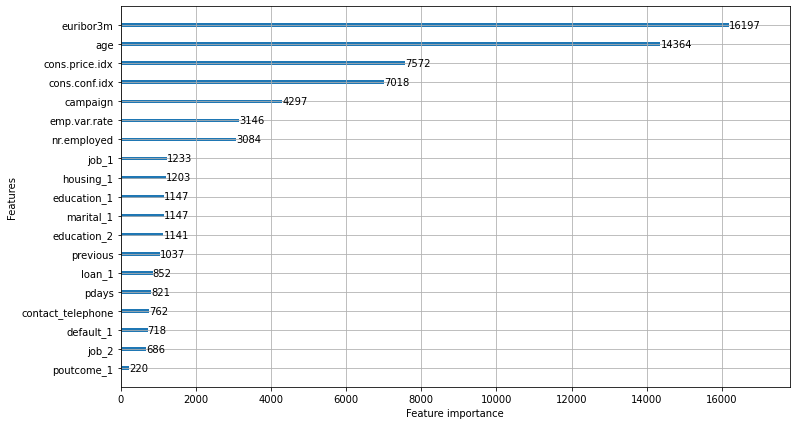

In [23]:
fig, ax = plt.subplots(figsize=(12,7))
lgbm.plot_importance(model, ax=ax)
ax.set_title("")
plt.show()

In [24]:
te_data.loc[:, 'y_p'] = te_p[:,1]

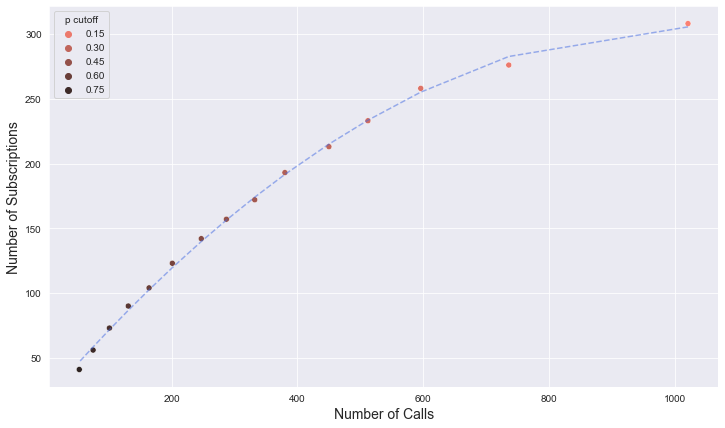

In [25]:
ys = te_data[['y', 'y_p']].copy()
ys = ys.replace(['no', 'yes'], [0, 1])

p_cutoff = np.arange(0.1, 0.85, 0.05)

n = len(p_cutoff)
num_calls = np.empty(n, dtype=np.int32)
num_subs = np.empty(n, dtype=np.int32)

for i, p in enumerate(p_cutoff):
    ys_cutoff = ys[ys['y_p']>p]
    num_calls[i] = len(ys_cutoff)
    num_subs[i] = ys_cutoff['y'].sum()
    

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,7))

z = np.polyfit(num_calls, num_subs, 2)
trend_y = [z[0]*np.square(n)+z[1]*n+z[2] for n in num_calls]
z = np.polyfit(num_calls, num_subs, 2)
pal = sns.color_palette("dark:salmon_r", as_cmap=True)
sns.scatterplot(x=num_calls, y=num_subs, hue=p_cutoff, palette=pal)
ax.plot(num_calls, trend_y, color=r'#4169E1', linestyle='--', alpha=0.5)

ax.set_xlabel('Number of Calls', fontsize=14)
ax.set_ylabel('Number of Subscriptions', fontsize=14)
ax.legend(title='p cutoff')
plt.show()